In [1]:
import pandas as pd
import pyam
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import aneris

In [2]:
results_19_path = '../../../data/SOD/model_results/to_share/model_results_to_share_Chapter_19.xlsx'

In [7]:
df_19 = pyam.IamDataFrame(results_19_path)
df_3_groups = df_19.filter(region=[
    'High-Income',
    'Low-Income',
    'Middle-Income',
])
df_6_groups = df_19.filter(region=[
    'High-Income, High Density',
    'High-Income, Low Density',
    'Low-Income, High Density',
    'Low-Income, Low Density',
    'Middle-Income, High Density',
    'Middle-Income, Low Density'])

[INFO] 11:41:28 - pyam.core: Reading file ..\..\..\data\SOD\model_results\to_share\model_results_to_share_Chapter_19.xlsx


# Emissions|CO2|Energy

In [4]:
df_3_groups_emissions = df_3_groups.filter(variable=['Emissions|CO2|AFOLU','Emissions|CO2|Energy', ])
df_6_groups_emissions = df_6_groups.filter(variable=['Emissions|CO2|AFOLU','Emissions|CO2|Energy', ])

df_3_groups_emissions.multiply('Emissions|CO2|AFOLU', 1, 'Emissions|CO2|Land Use', ignore_units='Mt CO2/yr', append=True)
df_6_groups_emissions.multiply('Emissions|CO2|AFOLU', 1, 'Emissions|CO2|Land Use', ignore_units='Mt CO2/yr', append=True)

df_3_groups_emissions = df_3_groups_emissions.filter(variable=['Emissions|CO2|Energy', 'Emissions|CO2|Land Use'])
df_6_groups_emissions = df_6_groups_emissions.filter(variable=['Emissions|CO2|Energy', 'Emissions|CO2|Land Use'])

c:\PBLprogs\miniforge3\lib\site-packages\pyam\plotting.py:466: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  pd.concat([_df, _rows.loc[_rows.index.difference(_df.index)]])
c:\PBLprogs\miniforge3\lib\site-packages\pyam\plotting.py:461: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  _rows = pd.concat(
c:\PBLprogs\miniforge3\lib\site-packages\pyam\plotting.py:461: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the ol

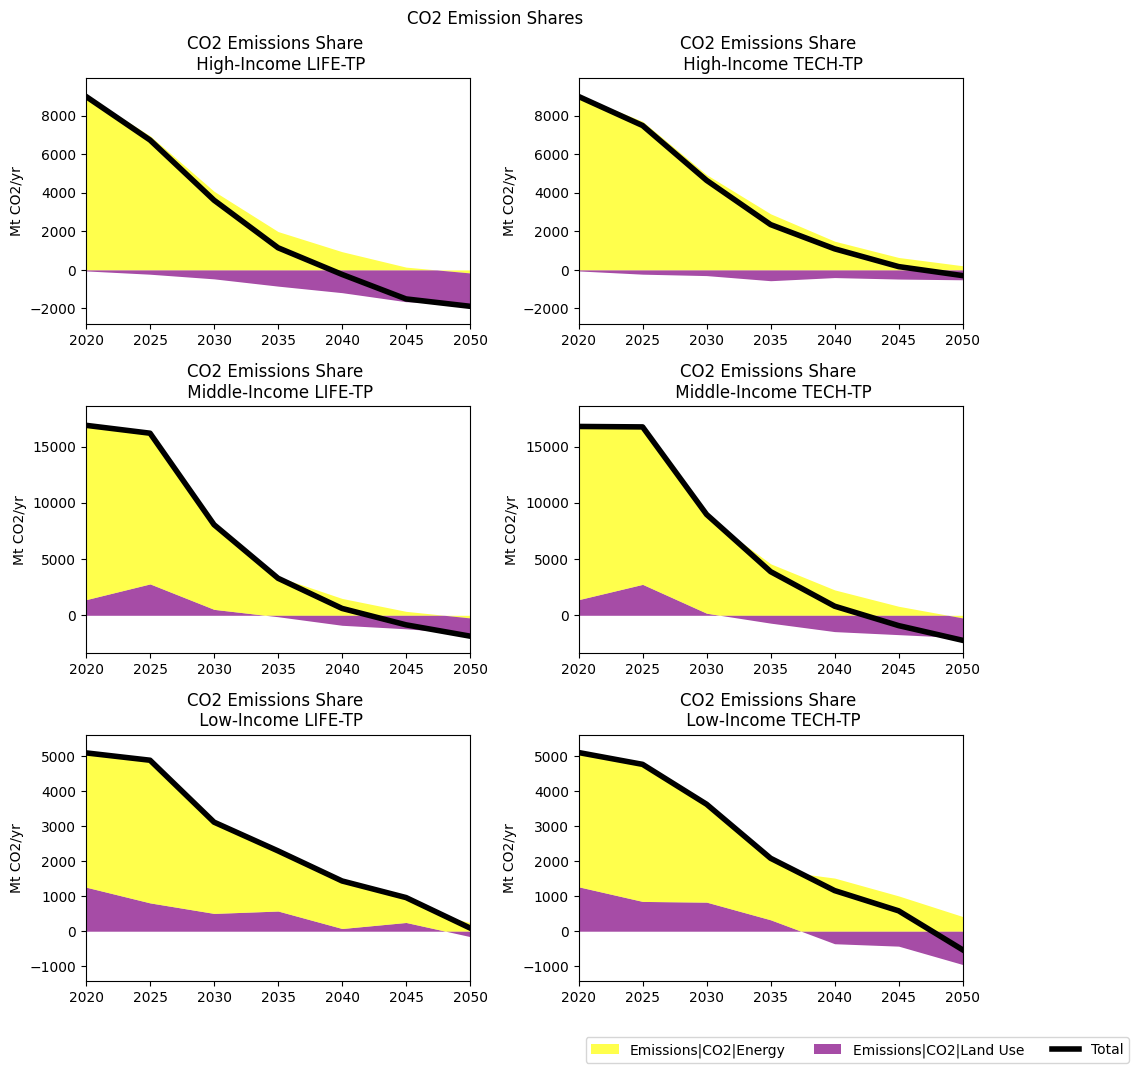

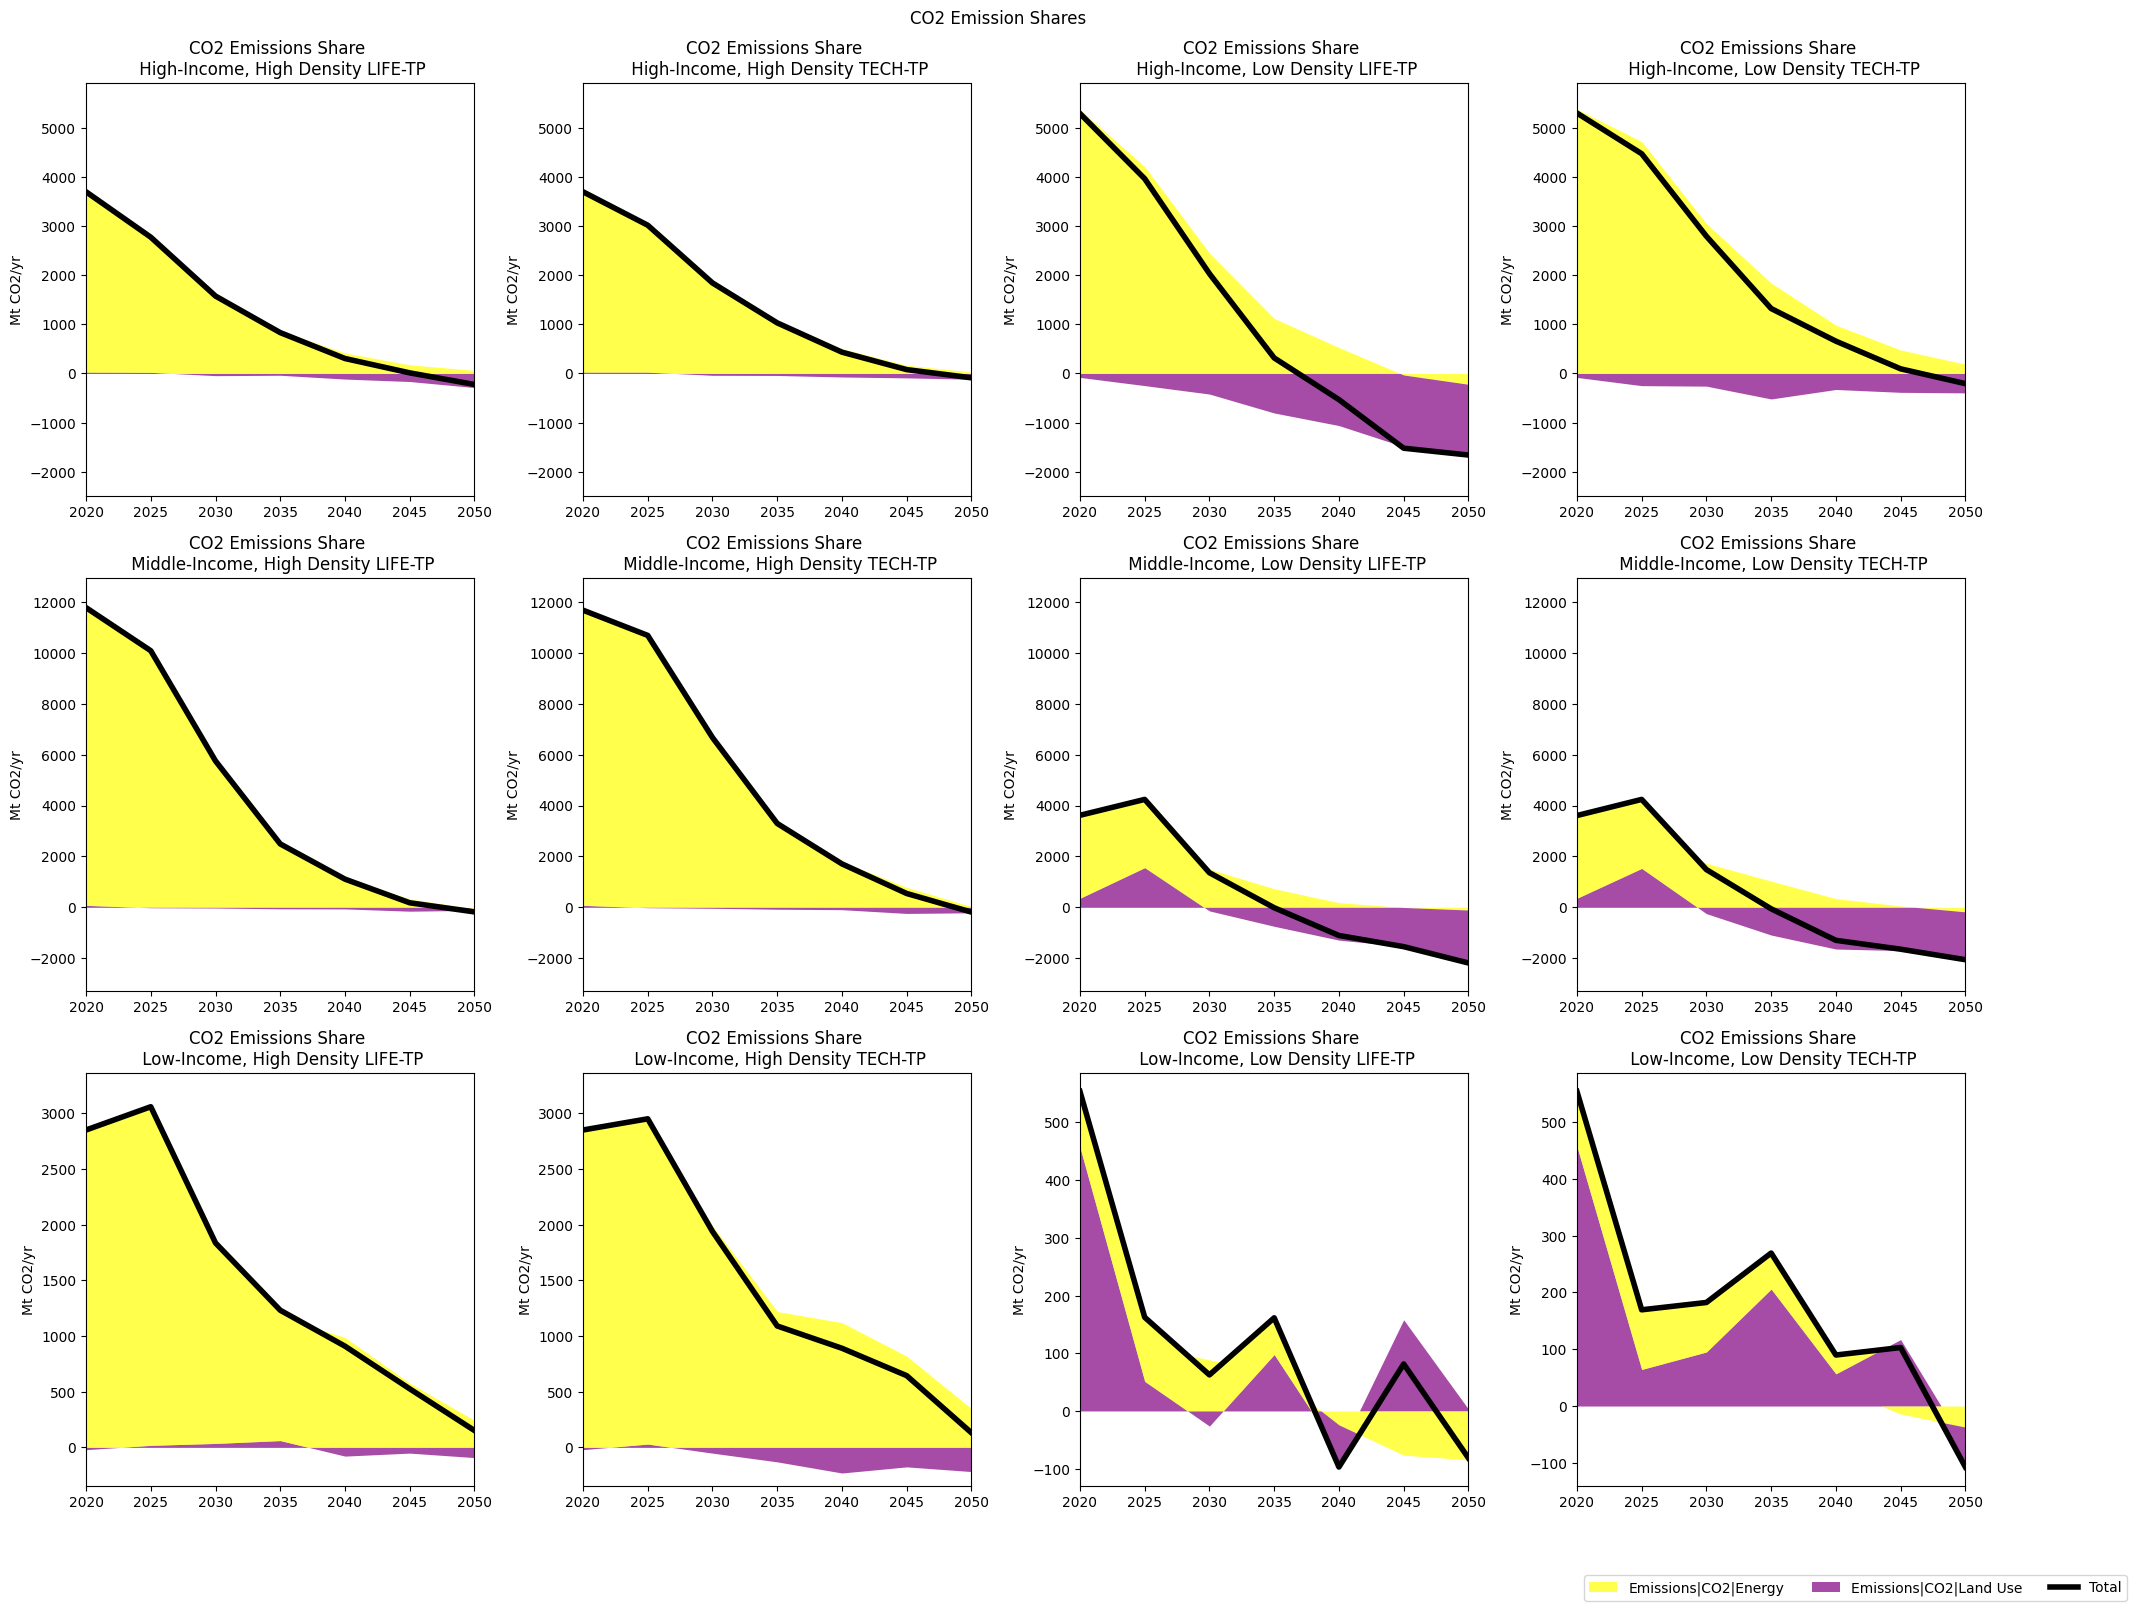

In [5]:
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["yellow","purple",])

for group in [df_3_groups_emissions, df_6_groups_emissions]: # 

    df_emissions_co2_geo = group.copy()
    # Get unique regions and change the order for creating subplots
    if len(df_emissions_co2_geo.region) == 6:
        # Create subplots based on the number of unique regions
        nrows=3 
        ncols=4
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15), sharey=False)
        unique_regions = ['High-Income, High Density',
                            'High-Income, Low Density',
                            'Middle-Income, High Density',
                            'Middle-Income, Low Density',
                            'Low-Income, High Density',
                            'Low-Income, Low Density',
                            ]
    elif len(df_emissions_co2_geo.region) == 3:
        nrows=3 
        ncols=2
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10), sharey=False)
        unique_regions = ['High-Income',
                          'Middle-Income',
                          'Low-Income',
                            ]

    # Iterate through each region and plot in respective subplot
    axes_flat  = axes.flatten()
    num_scenarios = len(df_emissions_co2_geo.scenario)

    row_min_values = [np.inf] * nrows
    row_max_values = [-np.inf] * nrows

    # Iterate through each region and scenario, plot in respective subplot
    # Manually
    for idx_region, region in enumerate(unique_regions):
        for idx_scen, scenario in enumerate(df_emissions_co2_geo.scenario):
            plot_idx = idx_region * num_scenarios + idx_scen
            ax = axes_flat[plot_idx]  # Select the current subplot
            # print(region, scenario, plot_idx)
            
            data=df_emissions_co2_geo.filter(variable=['Emissions|CO2|Energy', 'Emissions|CO2|Land Use',],
                                            scenario=scenario, 
                                            region=region,
                                            year=[
                                                2020,
                                                2025,
                                                2030,
                                                2035,
                                                2040,
                                                2045,
                                                2050,])

            data.plot.stack(title=f'CO2 Emissions Share \n {region} {scenario}',
                            total=True,
                            ax=ax, 
                            alpha=0.7, 
                            cmap=cmap)
            
            ax.set(xlabel=None)
            ax.legend().set_visible(False)
            ax.set_xlim(2020, 2050)
            plt.tight_layout() 

            # Get the maximum and minimum values plotted in this subplot
            max_value = max(max(data.timeseries().max()), max(data.timeseries().sum()))
            min_value = min(min(data.timeseries().min()), min(data.timeseries().sum()))
            
            # Determine the row index from the flattened index
            row_idx = plot_idx // ncols
            
            # Update the row min and max values
            row_max_values[row_idx] = max(row_max_values[row_idx], max_value)
            row_min_values[row_idx] = min(row_min_values[row_idx], min_value)

    # Set the y-limits for each row based on the min and max values
    for row_idx in range(nrows):
        for col_idx in range(ncols):
            if not (row_idx == 2 and col_idx > 1):
                ax = axes[row_idx, col_idx] if nrows > 1 else axes[col_idx]
                ax.set_ylim(min(0, row_min_values[row_idx] * 1.5), row_max_values[row_idx] * 1.1)    
            
    axes = axes.reshape(nrows, ncols)

    axes[-1, -1].legend(loc='upper left', bbox_to_anchor=(0, -0.2), ncol=3)
    fig.suptitle(f'CO2 Emission Shares', y=1.01)

    plt.savefig(
        f"../../../plots/SOD/chpt_19/{len(unique_regions)}_group/CO2_Emission_Shares.png",
        bbox_inches='tight'
    )
    plt.savefig(
        f"../../../plots/SOD/chpt_19/{len(unique_regions)}_group/CO2_Emission_Shares.svg",
        bbox_inches='tight'
    )
    # plt.close()

# Primary and Final Energy Stacked

In [13]:
energy_vars=['Primary Energy',
            'Primary Energy|Biomass',
            'Primary Energy|Coal',
            'Primary Energy|Gas',
            'Primary Energy|Non-Biomass Renewables',
            'Primary Energy|Nuclear',
            'Primary Energy|Oil',
            'Secondary Energy|Electricity',
            'Secondary Energy|Electricity|Biomass',
            'Secondary Energy|Electricity|Coal',
            'Secondary Energy|Electricity|Gas',
            'Secondary Energy|Electricity|Non-Biomass Renewables',
            'Secondary Energy|Electricity|Nuclear',
            'Secondary Energy|Electricity|Oil',
            'Final Energy',
            'Final Energy|Bunkers',
            'Final Energy|Industry',
            'Final Energy|Other Sector',
            'Final Energy|Residential and Commercial',
            'Final Energy|Transportation',
           ]

df_3_energy_geo_trans = df_3_groups.filter(
    variable=energy_vars,
    scenario=['TECH-TP', 'LIFE-TP']
)
print(df_6_groups)
df_6_energy_geo_trans = df_6_groups.filter(
    variable=energy_vars,
    scenario=['TECH-TP', 'LIFE-TP']
)

df_3_energy_geo_ref = df_3_groups.filter(
    variable=energy_vars,
    scenario=['REF']
)

df_6_energy_geo_ref = df_6_groups.filter(
    variable=energy_vars,
    scenario=['REF']
)

df_6_energy_geo_trans.timeseries()

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : Biodiversity, Emissions, Energy, Land, Macro_Economy (5)
 * scenario : LIFE-TP, REF, TECH-TP (3)
Timeseries data coordinates:
   region   : High-Income, High Density, High-Income, Low Density, ... Middle-Income, Low Density (6)
   variable : Area, Emissions|CH4, Emissions|CO2, ... Terrestrial Biodiversity|MSA|Vertebrates (40)
   unit     : %, EJ / million / a, EJ/yr, Mt CH4/yr, ... t CO2-equiv/yr (12)
   year     : 2010, 2020, 2025, 2030, 2035, 2040, 2045, 2050 (8)


2010  \
model  scenario region                     variable                                           unit            
Energy LIFE-TP  High-Income, High Density  Final Energy                                       EJ/yr  60.800   
                                           Final Energy|Bunkers                               EJ/yr   4.340   
                                           Final Energy|Industry                              EJ/yr  19.500   
                                           Final Energy|Other Sector                          EJ/yr   1.420   
                                           Final Energy|Residential and Commercial            EJ/yr  20.300   
...                                                                                                     ...   
       TECH-TP  Middle-Income, Low Density Secondary Energy|Electricity|Coal                  EJ/yr   1.370   
                                           Secondary Energy|Electricity|Gas                   EJ/yr   1.680   
                                           Secondary Energy|Electricity|Non-Biomass Renewa... EJ/yr   2.290   
                                           Secondary Energy|Electricity|Nuclear               EJ/yr   0.739   
                                           Secondary Energy|Electricity|Oil                   EJ/yr   0.247   

                                                                                                       2020  \
model  scenario region                     variable                                           unit            
Energy LIFE-TP  High-Income, High Density  Final Energy                                       EJ/yr  52.700   
                                           Final Energy|Bunkers                               EJ/yr   3.040   
                                           Final Energy|Industry                              EJ/yr  17.500   
                                           Final Energy|Other Sector                          EJ/yr   1.220   
                                           Final Energy|Residential and Commercial            EJ/yr  18.300   
...                                                                                                     ...   
       TECH-TP  Middle-Income, Low Density Secondary Energy|Electricity|Coal                  EJ/yr   1.970   
                                           Secondary Energy|Electricity|Gas                   EJ/yr   2.800   
                                           Secondary Energy|Electricity|Non-Biomass Renewa... EJ/yr   2.700   
                                           Secondary Energy|Electricity|Nuclear               EJ/yr   1.010   
                                           Secondary Energy|Electricity|Oil                   EJ/yr   0.324   

                                                                                                       2025  \
model  scenario region                     variable                                           unit            
Energy LIFE-TP  High-Income, High Density  Final Energy                                       EJ/yr  46.700   
                                           Final Energy|Bunkers                               EJ/yr   3.710   
                                           Final Energy|Industry                              EJ/yr  16.300   
                                           Final Energy|Other Sector                          EJ/yr   1.210   
                                           Final Energy|Residential and Commercial            EJ/yr  15.600   
...                                                                                                     ...   
       TECH-TP  Middle-Income, Low Density Secondary Energy|Electricity|Coal                  EJ/yr   1.540   
                                           Secondary Energy|Electricity|Gas                   EJ/yr   2.540   
                                           Secondary Energy|Electricity|Non-Biomass Renewa... EJ/yr   2.9

c:\PBLprogs\miniforge3\lib\site-packages\pyam\plotting.py:466: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  pd.concat([_df, _rows.loc[_rows.index.difference(_df.index)]])
c:\PBLprogs\miniforge3\lib\site-packages\pyam\plotting.py:466: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  pd.concat([_df, _rows.loc[_rows.index.difference(_df.index)]])
c:\PBLprogs\miniforge3\lib\site-packages\pyam\plotting.py:466: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when de

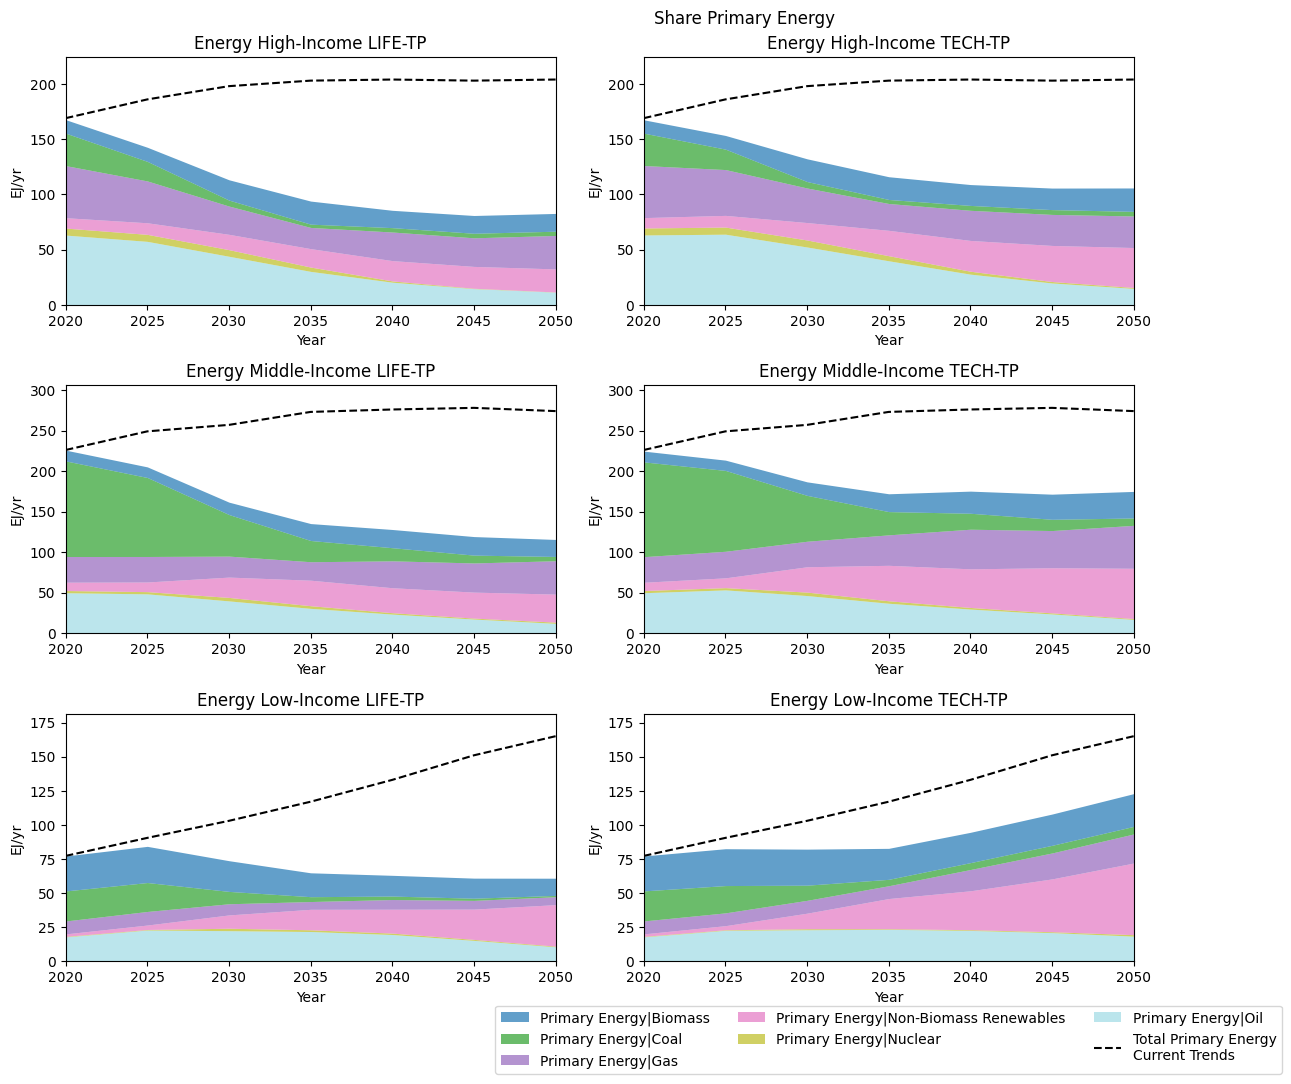

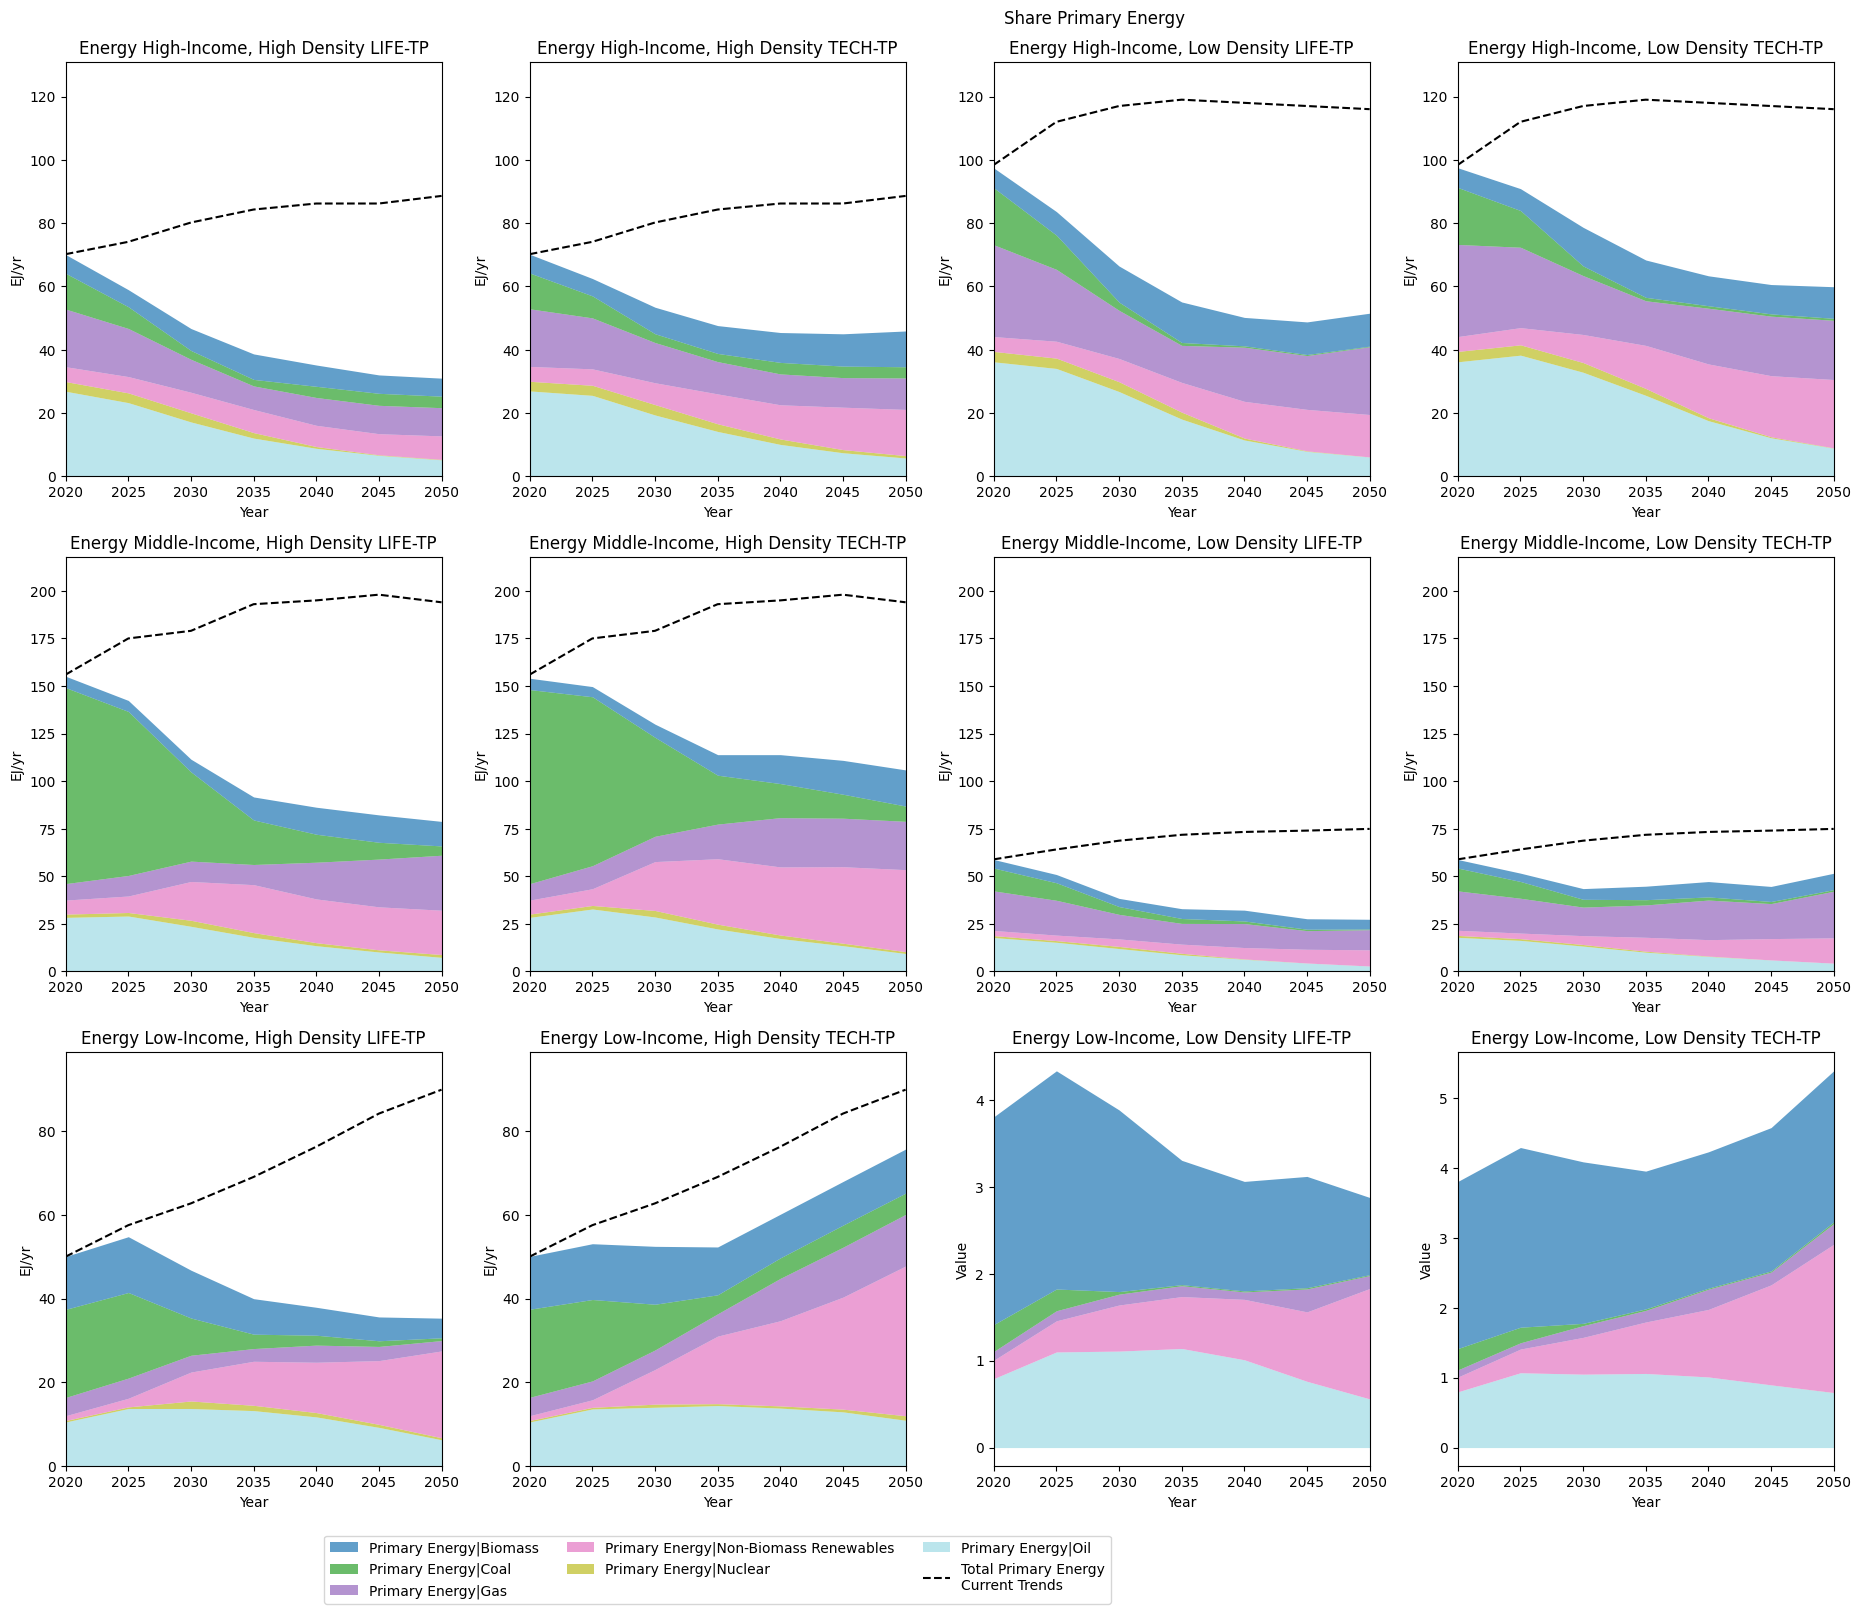

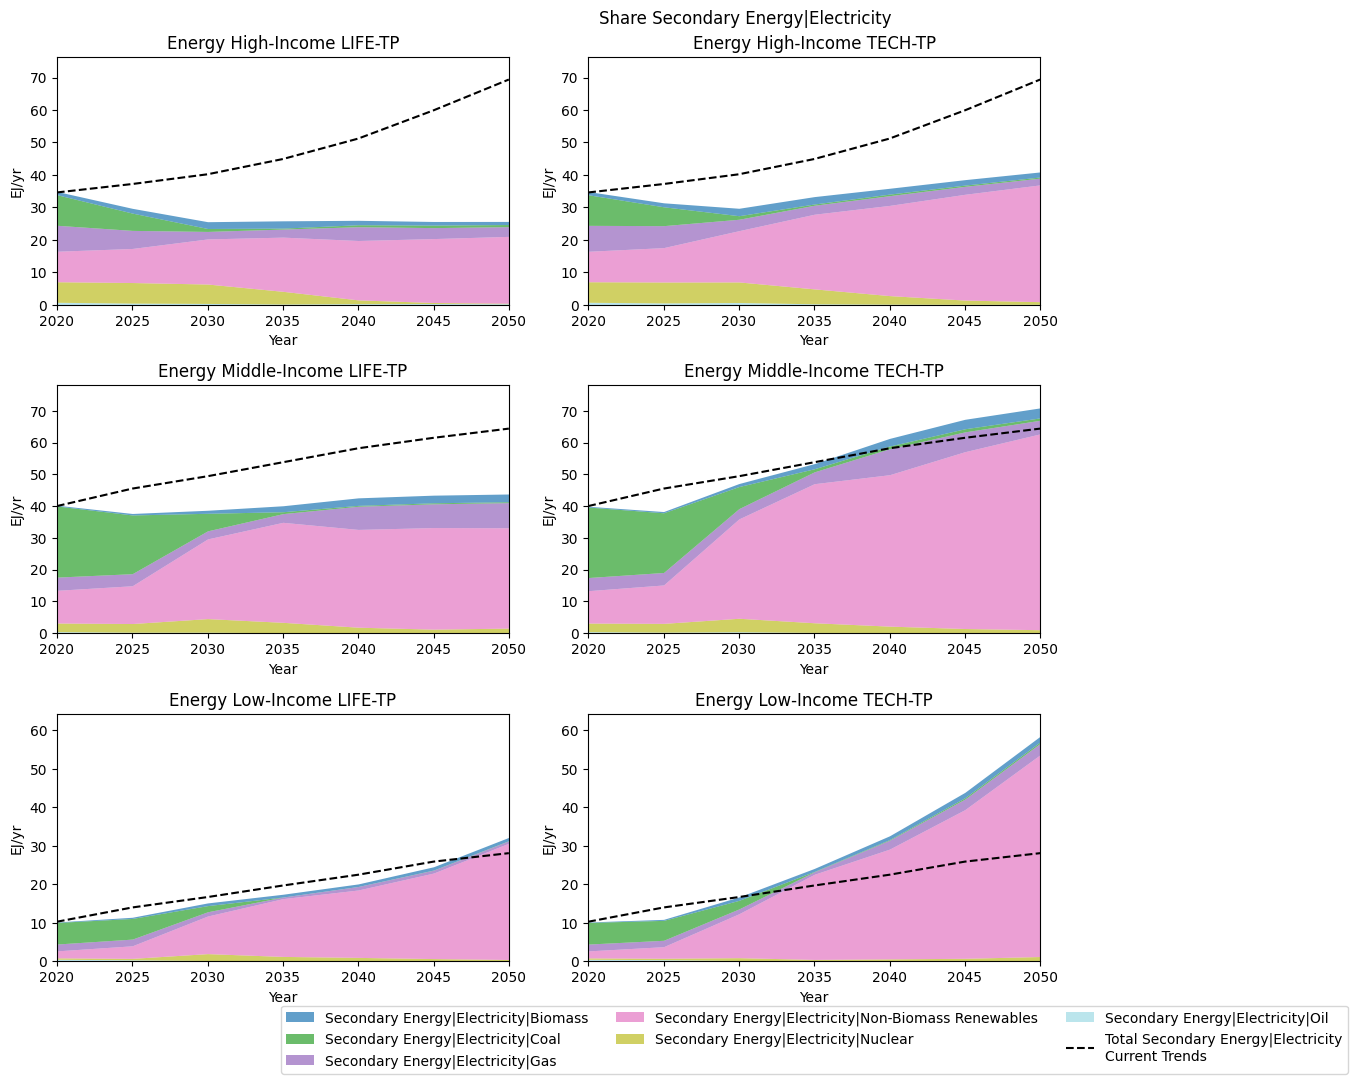

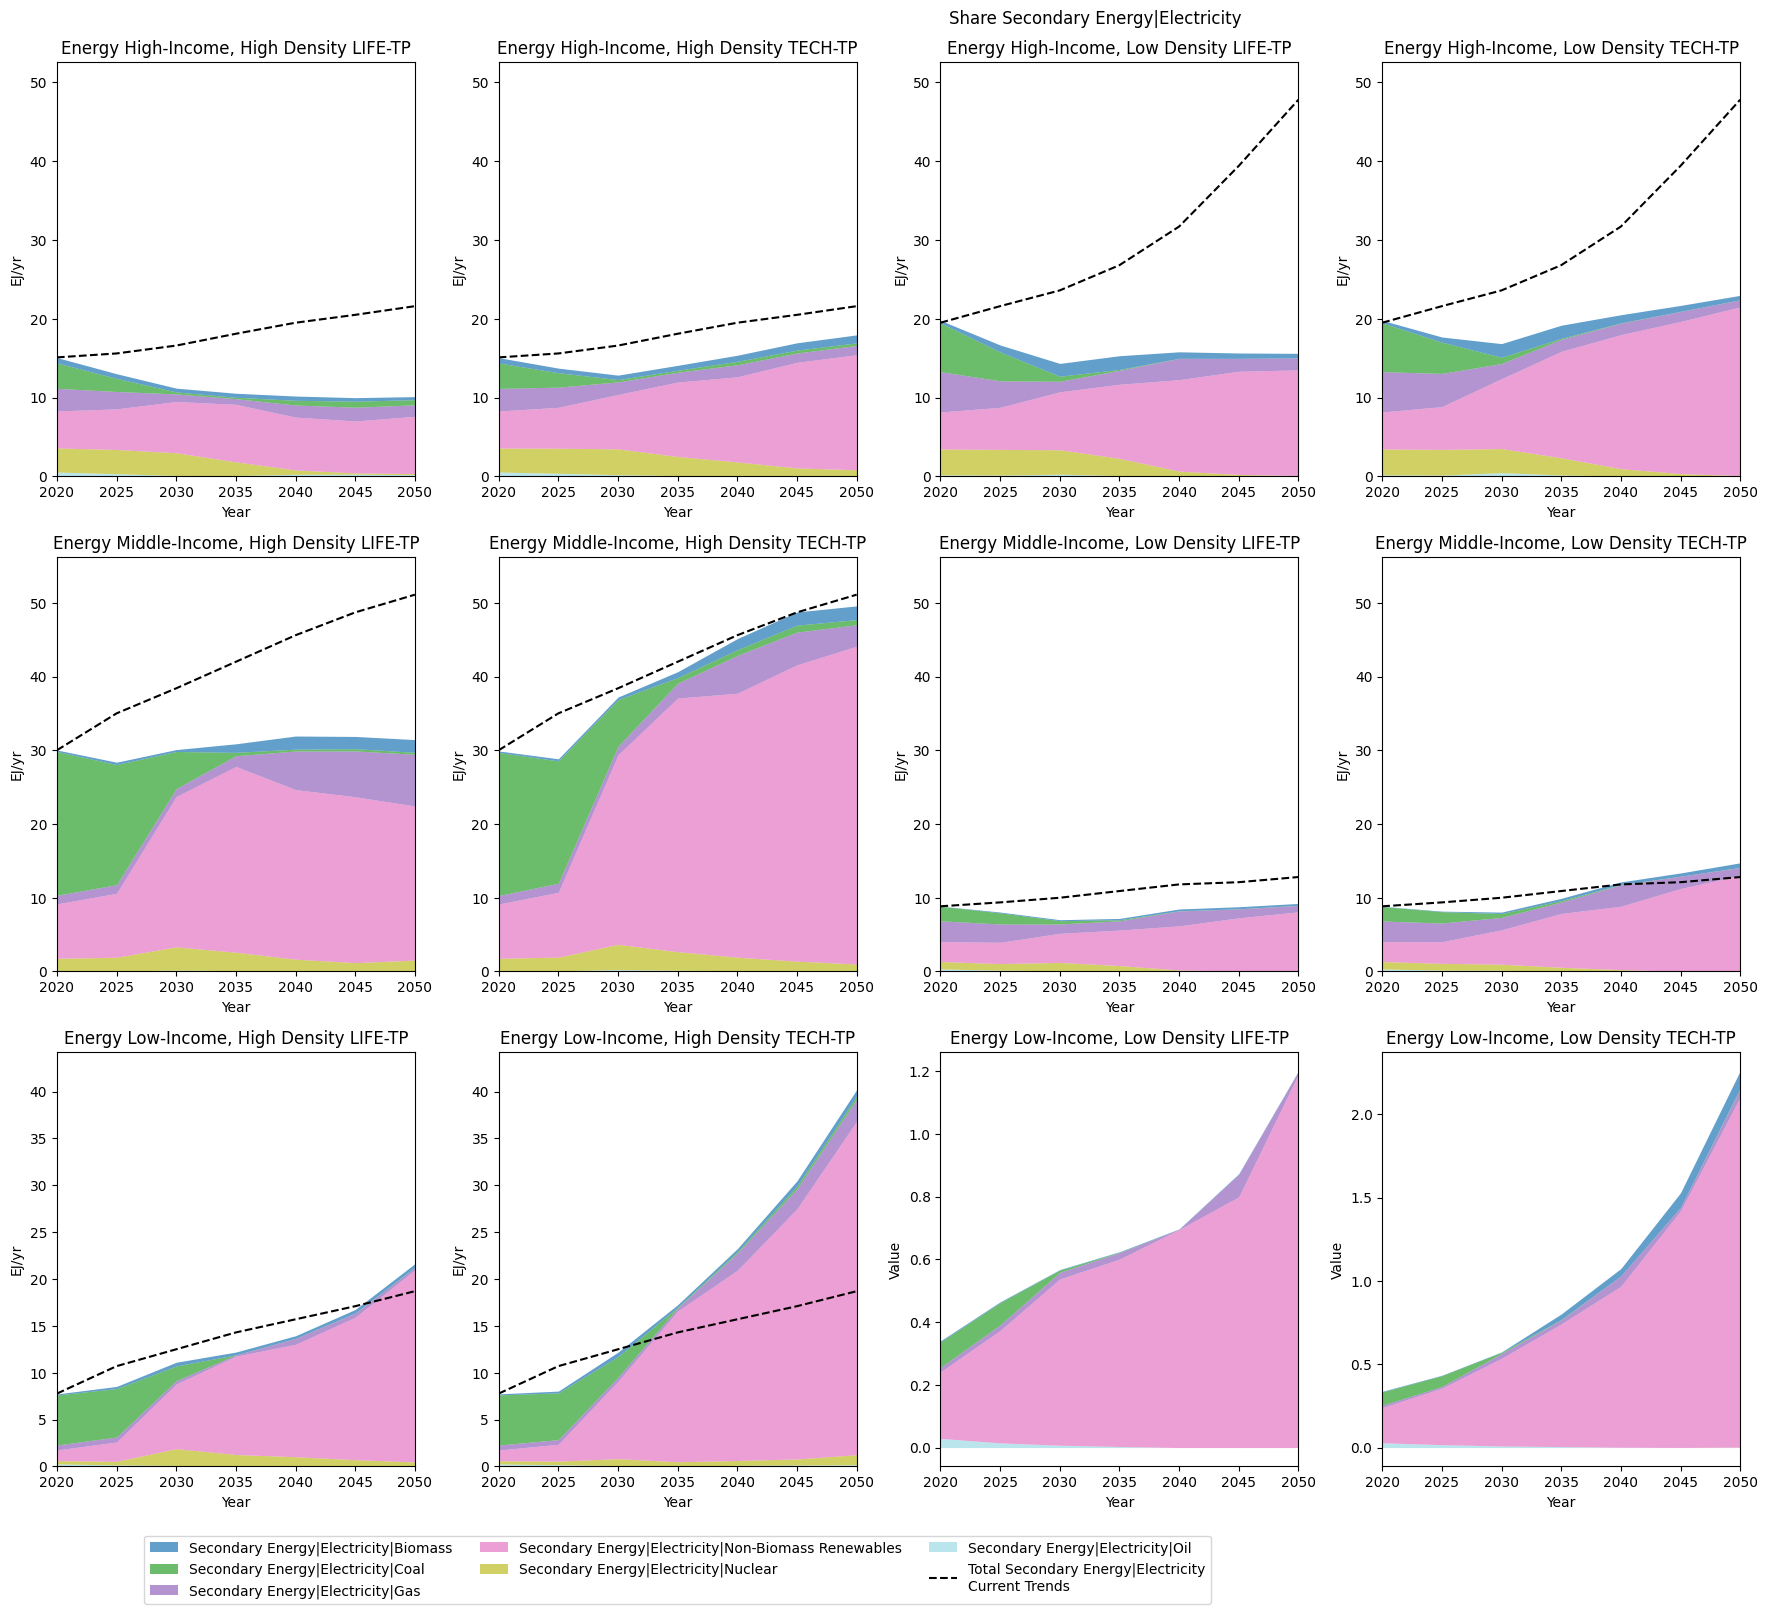

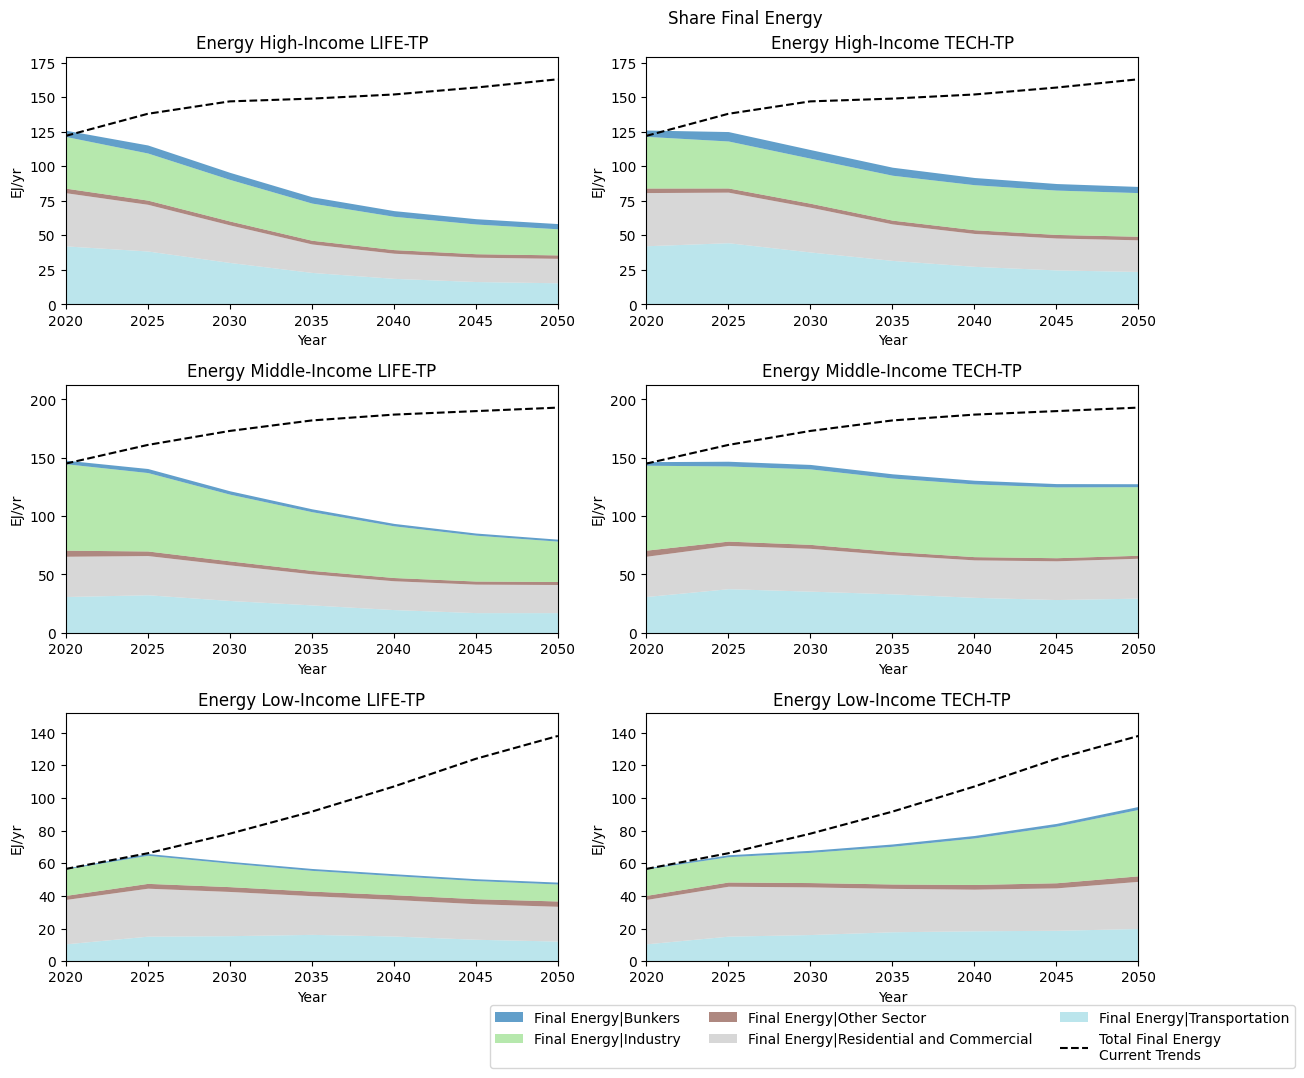

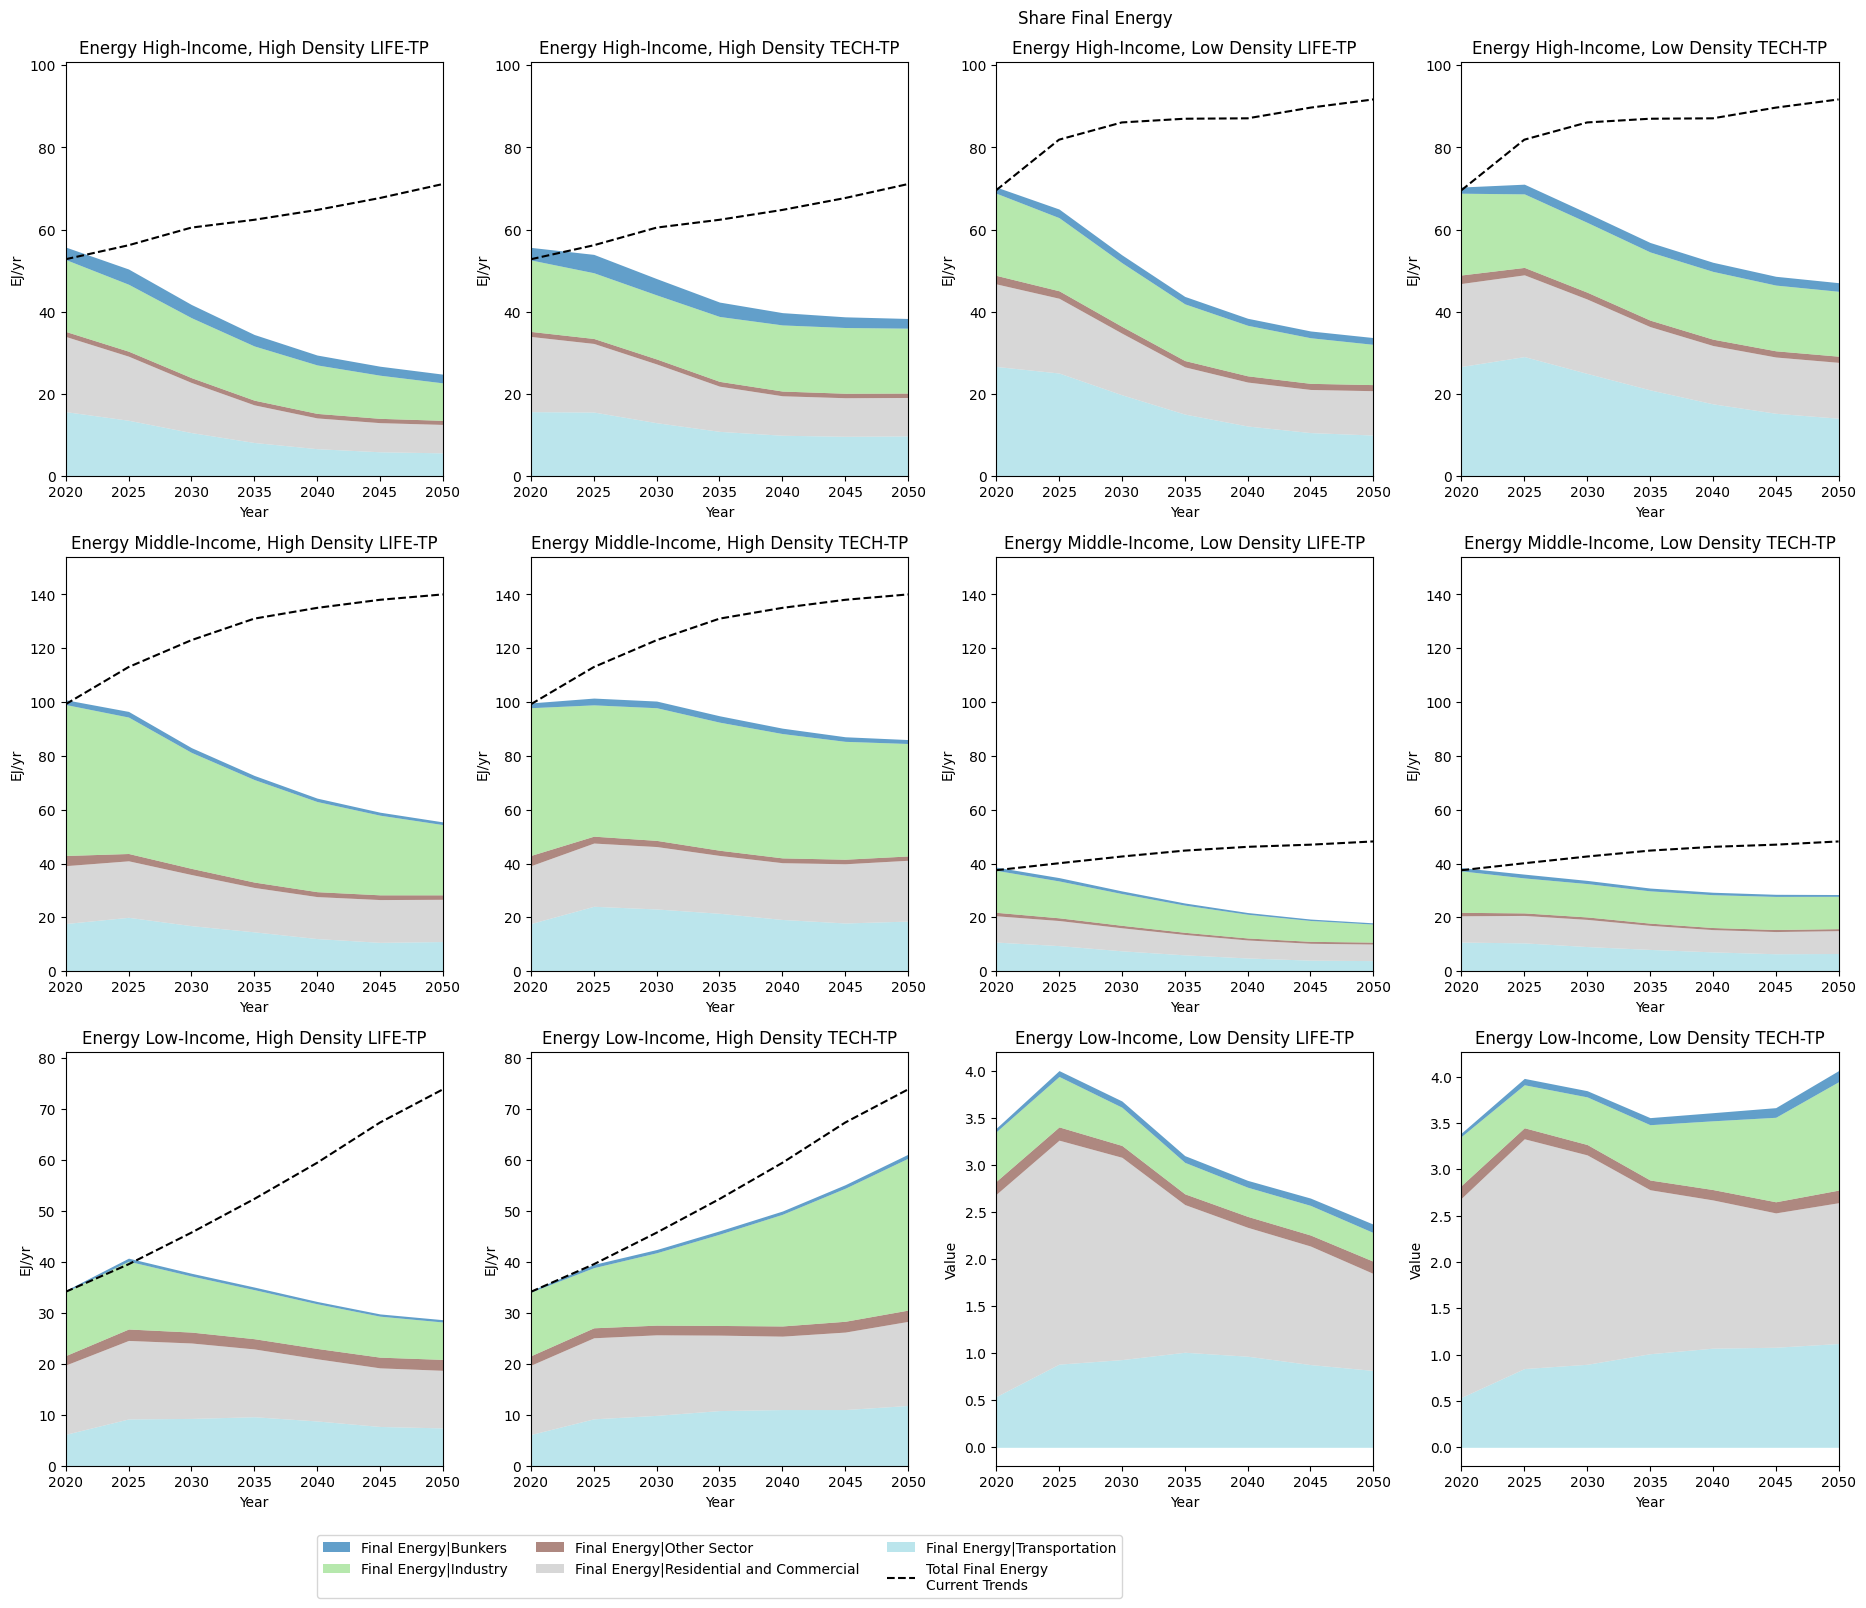

In [14]:
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["yellow","purple",])


for variable in ['Primary Energy', 'Secondary Energy|Electricity', 'Final Energy']: # 
    # Plotting
    for group in [df_3_energy_geo_trans, df_6_energy_geo_trans]: # 

        df_energy_geo = group.copy()
        # Get unique regions for creating subplots
        

        if len(df_energy_geo.region) == 6:
            # Create subplots based on the number of unique regions
            nrows=3 
            ncols=4
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(22, 15), sharey=False)
            unique_regions = ['High-Income, High Density',
                                'High-Income, Low Density',
                                'Middle-Income, High Density',
                                'Middle-Income, Low Density',
                                'Low-Income, High Density',
                                'Low-Income, Low Density',
                                ]
            total_ref = df_6_energy_geo_ref
        elif len(df_energy_geo.region) == 3:
            nrows=3 
            ncols=2
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10), sharey=False)
            unique_regions = ['High-Income', 'Middle-Income', 'Low-Income']
            total_ref = df_3_energy_geo_ref

        # Iterate through each region and plot in respective subplot
        axes_flat  = axes.flatten()
        num_scenarios = len(df_energy_geo.scenario)

        row_min_values = [np.inf] * nrows
        row_max_values = [-np.inf] * nrows
        # print(unique_regions)
        # Iterate through each region and scenario, plot in respective subplot
        for idx_region, region in enumerate(unique_regions):
            for idx_scen, scenario in enumerate(df_energy_geo.scenario):
                plot_idx = idx_region * num_scenarios + idx_scen
                ax = axes_flat[plot_idx]  # Select the current subplot
                # print(region, scenario, plot_idx)

                data=df_energy_geo.filter(variable=f'{variable}|*', 
                                          scenario=scenario, 
                                          region=region,
                                          year=[2005,
                                                2010,
                                                2015,
                                                2020,
                                                2025,
                                                2030,
                                                2035,
                                                2040,
                                                2045,
                                                2050,])

                data.plot.stack(title=f'Energy {region} {scenario}',
                                ax=ax, 
                                alpha=0.7, 
                                cmap="tab20"
                )
                
                ax.set(xlabel=None)
                
                ax.set_xlim(2020, 2050)
                plt.tight_layout()

                
                total_plot = total_ref.filter(variable=variable, region=region)
                total_plot.plot.line(label=f'Total {variable}\nCurrent Trends', 
                                     linestyle='--', 
                                     color='black',
                                     ax=ax,
                                     title=False,
                                     )
                ax.legend().set_visible(False)

                # Get the maximum and minimum values plotted in this subplot
                if region == 'Low-Income, Low Density':
                    max_value = max(data.timeseries().sum())
                else:
                    max_value =  max(max(total_plot.timeseries().sum()), max(data.timeseries().sum()))
                min_value = min(data.timeseries().sum())
                
                # Determine the row index from the flattened index
                row_idx = plot_idx // ncols
                
                # Update the row min and max values
                row_max_values[row_idx] = max(row_max_values[row_idx], max_value)
                # print(row_idx, row_max_values[row_idx])
                row_min_values[row_idx] = min(row_min_values[row_idx], min_value)  
 
        # Set the y-limits for each row based on the min and max values
        for row_idx in range(nrows):
            for col_idx in range(ncols):
                if not (row_idx == 2 and col_idx > 1):
                    ax = axes[row_idx, col_idx] if nrows > 1 else axes[col_idx]
                    ax.set_ylim(min(0,row_min_values[row_idx] * 1.1), row_max_values[row_idx] * 1.1)  

        axes[-1, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
        fig.suptitle(f'Share {variable}', y=1.01)
        variable_name = variable.replace("|", "_").replace(" ", "_").replace("/", "")
        plt.savefig(
        f"../../../plots/SOD/chpt_19/{len(unique_regions)}_group/{variable_name}_Shares.png",
        bbox_inches='tight'
        )
        plt.savefig(
        f"../../../plots/SOD/chpt_19/{len(unique_regions)}_group/{variable_name}_Shares.svg",
        bbox_inches='tight'
        )
        # plt.close()

# Land Cover Change

In [15]:
df_3_land = df_3_groups.filter(variable=[
    'Land Cover|Other',
    'Land Cover|Cropland',
    "Land Cover|Forest and Other Natural Land",
    'Land Cover|Pasture',
],)

df_6_land = df_6_groups.filter(variable=[
    'Land Cover|Other',
    'Land Cover|Cropland',
    "Land Cover|Forest and Other Natural Land",
    'Land Cover|Pasture',
],)

df_3_land.timeseries()

2010  \
model scenario region        variable                                 unit                 
Land  LIFE-TP  High-Income   Land Cover|Cropland                      million ha   312.0   
                             Land Cover|Forest and Other Natural Land million ha  2030.0   
                             Land Cover|Other                         million ha    23.3   
                             Land Cover|Pasture                       million ha   642.0   
               Low-Income    Land Cover|Cropland                      million ha   472.0   
                             Land Cover|Forest and Other Natural Land million ha  2080.0   
                             Land Cover|Other                         million ha    12.2   
                             Land Cover|Pasture                       million ha   791.0   
               Middle-Income Land Cover|Cropland                      million ha   438.0   
                             Land Cover|Forest and Other Natural Land million ha  2780.0   
                             Land Cover|Other                         million ha    21.5   
                             Land Cover|Pasture                       million ha   975.0   
      REF      High-Income   Land Cover|Cropland                      million ha     NaN   
                             Land Cover|Forest and Other Natural Land million ha     NaN   
                             Land Cover|Other                         million ha     NaN   
                             Land Cover|Pasture                       million ha     NaN   
               Low-Income    Land Cover|Cropland                      million ha     NaN   
                             Land Cover|Forest and Other Natural Land million ha     NaN   
                             Land Cover|Other                         million ha     NaN   
                             Land Cover|Pasture                       million ha     NaN   
               Middle-Income Land Cover|Cropland                      million ha     NaN   
                             Land Cover|Forest and Other Natural Land million ha     NaN   
                             Land Cover|Other                         million ha     NaN   
                             Land Cover|Pasture                       million ha     NaN   
      TECH-TP  High-Income   Land Cover|Cropland                      million ha   312.0   
                             Land Cover|Forest and Other Natural Land million ha  2030.0   
                             Land Cover|Other                         million ha    23.3   
                             Land Cover|Pasture                       million ha   642.0   
               Low-Income    Land Cover|Cropland                      million ha   472.0   
                             Land Cover|Forest and Other Natural Land million ha  2080.0   
                             Land Cover|Other                         million ha    12.2   
                             Land Cover|Pasture                       million ha   791.0   
               Middle-Income Land Cover|Cropland                      million ha   438.0   
                             Land Cover|Forest and Other Natural Land million ha  2780.0   
                             Land Cover|Other                         million ha    21.5   
                             Land Cover|Pasture                       million ha   975.0   

                                                                                    2020  \
model scenario region        variable                                 unit                 
Land  LIFE-TP  High-Income   Land Cover|Cropland                      million ha   311.0   
                             Land Cover|Forest and Other Natural Land million ha  2040.0   
                             Land Cover|Other                         million ha    26.5   
                             Land Cover|Pasture                       million ha   621.0   
               Low-Income    Land C

In [16]:
def calc_land_cover_change(pyam_df):
    df_land_data = pyam_df.data

    df_land_data = df_land_data[df_land_data['year'].isin([2020, 2030, 2050])]
    # Calculate the difference
    df_land_data = df_land_data.reset_index(drop=True)
    df_land_data['change'] = df_land_data['value'].diff()
    df_land_data = df_land_data[df_land_data['year'].isin([2030, 2050])] # , 2050
    # df_land_data = df_land_data[df_land_data['scenario'].isin(['REF'])]]
    df_land_data = df_land_data.sort_values(['year', 'change'])
    return df_land_data

df_3_land_data = calc_land_cover_change(df_3_land)
df_6_land_data = calc_land_cover_change(df_6_land)
df_6_land_data

,model,scenario,region,variable,unit,year,value,change
70,Land,LIFE-TP,"Middle-Income, Low Density",Land Cover|Pasture,million ha,2030,380.0,-83.0
202,Land,TECH-TP,"Middle-Income, Low Density",Land Cover|Pasture,million ha,2030,408.0,-55.0
22,Land,LIFE-TP,"High-Income, Low Density",Land Cover|Pasture,million ha,2030,514.0,-54.0
154,Land,TECH-TP,"High-Income, Low Density",Land Cover|Pasture,million ha,2030,546.0,-22.0
46,Land,LIFE-TP,"Low-Income, Low Density",Land Cover|Pasture,million ha,2030,192.0,-19.0
...,...,...,...,...,...,...,...,...
53,Land,LIFE-TP,"Middle-Income, High Density",Land Cover|Forest and Other Natural Land,million ha,2050,568.0,46.0
185,Land,TECH-TP,"Middle-Income, High Density",Land Cover|Forest and Other Natural Land,million ha,2050,564.0,50.0
197,Land,TECH-TP,"Middle-Income, Low Density",Land Cover|Forest and Other Natural Land,million ha,2050,2230.0,60.0
17,Land,LIFE-TP,"High-Income, Low Density",Land Cover|Forest and Other Natural Land,million ha,2050,1950.0,120.0


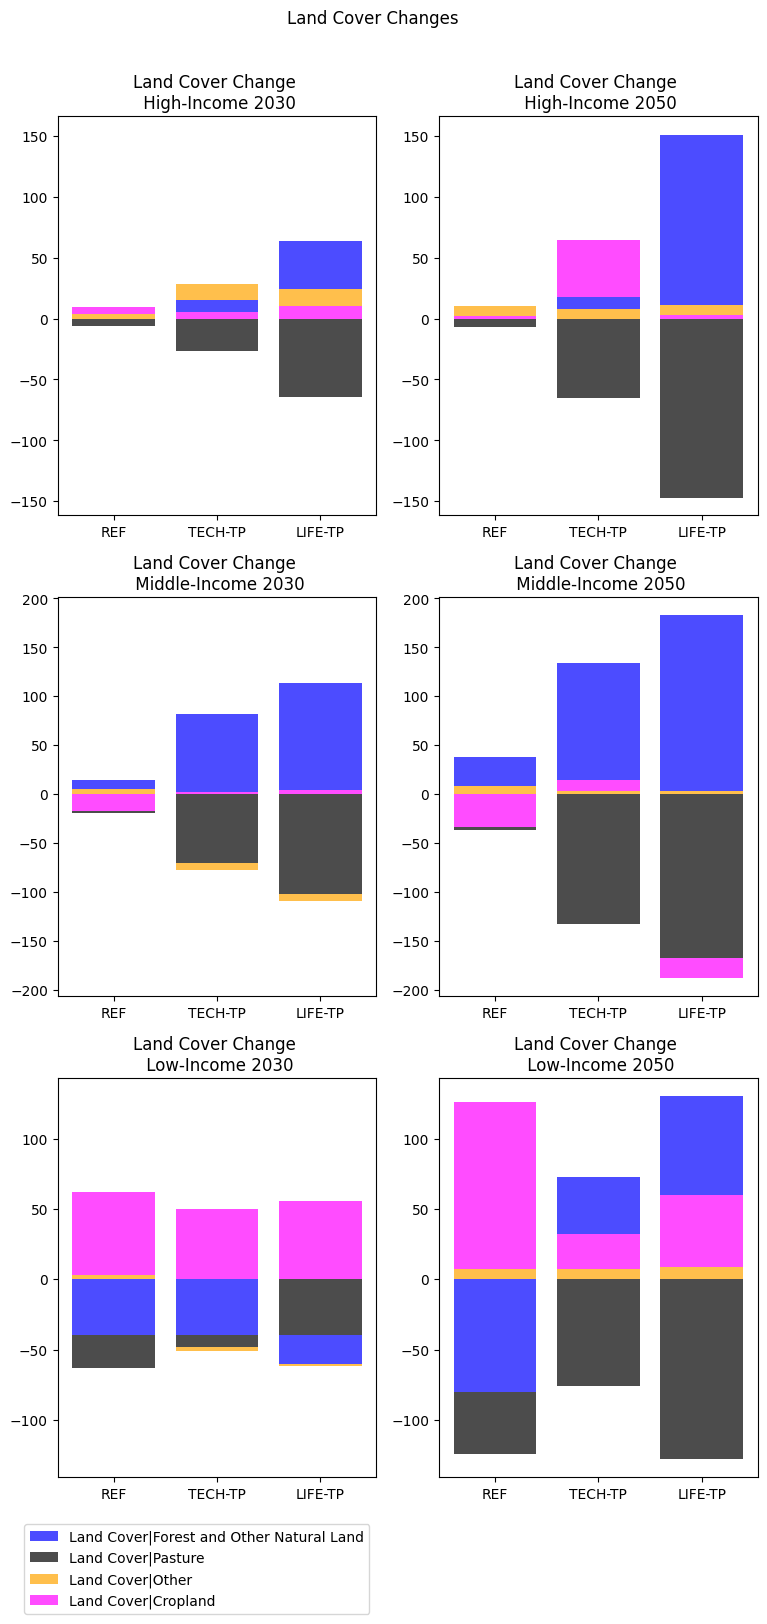

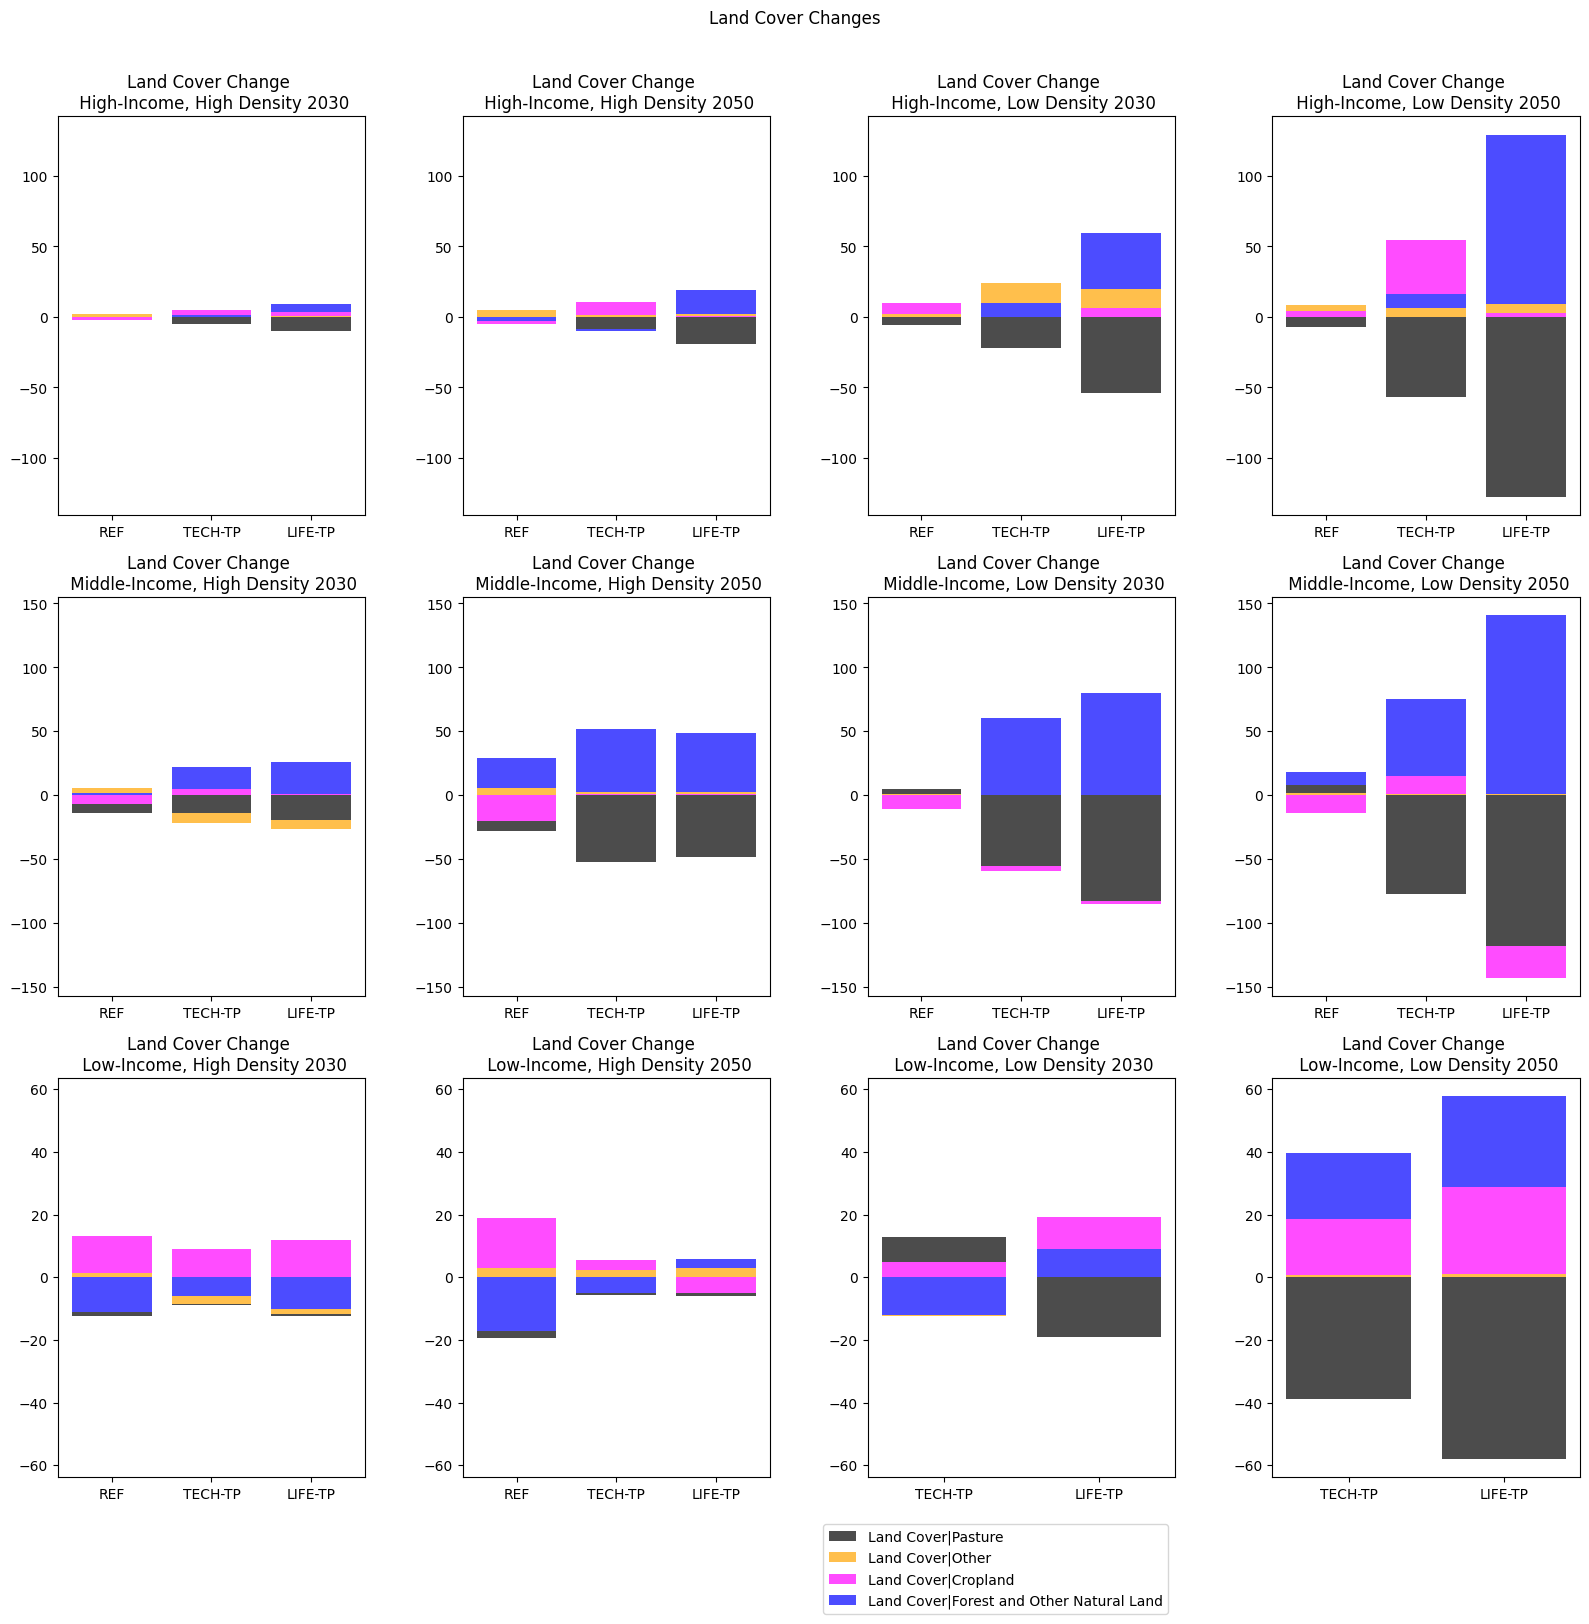

In [18]:
# Plotting
for group in [df_3_land_data, df_6_land_data]: #

    df_land_data = group.copy()
    # Get unique regions for creating subplots
    unique_regions = df_land_data.region.sort_values().unique()

    if len(df_land_data.region.sort_values().unique()) == 6:
        # Create subplots based on the number of unique regions
        nrows=3 
        ncols=4
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16), sharey=False)
        unique_regions = ['High-Income, High Density',
                                'High-Income, Low Density',
                                'Middle-Income, High Density',
                                'Middle-Income, Low Density',
                                'Low-Income, High Density',
                                'Low-Income, Low Density',
                                ]
    elif len(df_land_data.region.sort_values().unique()) == 3:
        nrows=3 
        ncols=2
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 16), sharey=False)
        unique_regions = ['High-Income', 'Middle-Income', 'Low-Income']

    # Iterate through each region and plot in respective subplot
    axes_flat  = axes.flatten()
    num_year = len(df_land_data.year.unique())

    row_min_values = [np.inf] * nrows
    row_max_values = [-np.inf] * nrows

    # Iterate through each region and scenario, plot in respective subplot
    for idx_region, region in enumerate(unique_regions):
        for idx_year, year in enumerate(df_land_data.year.unique()):
            plot_idx = idx_region * num_year + idx_year
            ax = axes_flat[plot_idx]  # Select the current subplot
            # print(region, year, plot_idx)

            df_land_data_temp = df_land_data[(df_land_data['year'] == year) & (df_land_data['region'] == region)]
            df_land_negative = df_land_data_temp[df_land_data_temp['change'] < 0]
            df_land_positive = df_land_data_temp[df_land_data_temp['change'] >= 0]

            # Assign colors to each category
            category_colors = {
                "Land Cover|Forest and Other Natural Land": "blue",
                # "Land Cover|Forest": "blue",
                "Land Cover|Other": "orange",
                "Land Cover|Cropland": "magenta",
                "Land Cover|Pasture": "black"
            }

            for scenario in ['REF','TECH-TP', 'LIFE-TP']:
                df_land_negative_temp = df_land_negative[df_land_negative['scenario'] == scenario]
                df_land_positive_temp = df_land_positive[df_land_positive['scenario'] == scenario]

                # Stacked column bar plot without error bars
                for i, category in enumerate(df_land_negative_temp['variable']):
                    category_values = df_land_negative_temp['change'].iloc[i]
                    category_bottom = df_land_negative_temp['change'].iloc[:i].sum()
                    ax.bar(
                        x=scenario,
                        height=category_values,
                        bottom=category_bottom,
                        color=category_colors[category],
                        alpha=0.7,
                        label=category
                    )

                # Stacked column bar plot without error bars
                for i, category in enumerate(df_land_positive_temp['variable']):
                    category_values = df_land_positive_temp['change'].iloc[i]
                    category_bottom = df_land_positive_temp['change'].iloc[:i].sum()
                    ax.bar(
                        x=scenario,
                        height=category_values,
                        bottom=category_bottom,
                        color=category_colors[category],
                        alpha=0.7,
                        label=category
                    )

                # Get the maximum and minimum values plotted in this subplot
                max_value = df_land_positive_temp.change.sum()
                min_value = df_land_negative_temp.change.sum()
                
                # Determine the row index from the flattened index
                row_idx = plot_idx // ncols
                
                # Update the row min and max values
                row_max_values[row_idx] = max(row_max_values[row_idx], max_value)
                # print(row_idx, row_max_values[row_idx])
                row_min_values[row_idx] = min(row_min_values[row_idx], min_value)  

            ax.set_title(f'Land Cover Change \n {region} {year}') 
            
    # Set the y-limits for each row based on the min and max values
    for row_idx in range(nrows):
        for col_idx in range(ncols):
            ax = axes[row_idx, col_idx] if nrows > 1 else axes[col_idx]
            ax.set_ylim(min(0,row_min_values[row_idx] * 1.1), row_max_values[row_idx] * 1.1)  

    # Create a unique legend for each subplot 
    handles, labels = ax.get_legend_handles_labels()
    axes[-1, -2].legend(handles=handles[:4], labels=labels[:4],  bbox_to_anchor=(1, -0.1))
    fig.suptitle(f'Land Cover Changes', y=1.01)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig(
        f"../../../plots/SOD/chpt_19/{len(unique_regions)}_group/land_cover_change.png",
        bbox_inches='tight'
    )
    plt.savefig(
        f"../../../plots/SOD/chpt_19/{len(unique_regions)}_group/land_cover_change.svg",
        bbox_inches='tight'
    )
    # plt.close()